In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import glob


In [2]:
filenames = glob.glob("dataset/*/*.jpg")
print(len(filenames))

# Load image files and Resize (h,w,ch) -> h = w < 100 , ch = 3 (R,G,B)
data = []
labels = []

for idx, img_path in enumerate(filenames):
    label = img_path.split(os.path.sep)[-2]

    img = image.load_img(img_path, target_size=(224, 224), interpolation="nearest")
    img = image.img_to_array(img)
    img = preprocess_input(img) ## using mobilenet_v2

    # update the data and labels lists, respectively
    labels.append(label)
    data.append(img)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

3762


In [3]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [8]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(3009, 224, 224, 3)
(3009, 2)
(753, 224, 224, 3)
(753, 2)


In [5]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...


/Users/thana/Workspace/Class/image_project/project/env/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2022-05-01 20:32:08.719554: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/20
94/94 [==============================] - 38s 383ms/step - loss: 0.3944 - accuracy: 0.8546 - val_loss: 0.1532 - val_accuracy: 0.9721
Epoch 2/20
94/94 [==============================] - 40s 428ms/step - loss: 0.1546 - accuracy: 0.9667 - val_loss: 0.0878 - val_accuracy: 0.9841
Epoch 3/20
94/94 [==============================] - 42s 446ms/step - loss: 0.1094 - accuracy: 0.9711 - val_loss: 0.0679 - val_accuracy: 0.9867
Epoch 4/20
94/94 [==============================] - 36s 377ms/step - loss: 0.0848 - accuracy: 0.9751 - val_loss: 0.0600 - val_accuracy: 0.9880
Epoch 5/20
94/94 [==============================] - 37s 387ms/step - loss: 0.0779 - accuracy: 0.9778 - val_loss: 0.0555 - val_accuracy: 0.9880
Epoch 6/20
94/94 [==============================] - 35s 375ms/step - loss: 0.0627 - accuracy: 0.9809 - val_loss: 0.0503 - val_accuracy: 0.9894
Epoch 7/20
94/94 [==============================] - 35s 373ms/step - loss: 0.0592 - accuracy: 0.9829 - val_loss: 0.0501 - val_accuracy: 0.9894

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       367
without_mask       0.99      0.99      0.99       386

    accuracy                           0.99       753
   macro avg       0.99      0.99      0.99       753
weighted avg       0.99      0.99      0.99       753

[INFO] saving mask detector model...


/Users/thana/Workspace/Class/image_project/project/env/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


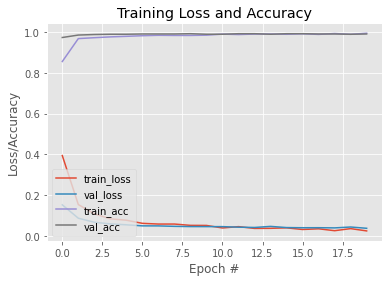

In [7]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("model", save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("test")